<a href="https://colab.research.google.com/github/JoDeMiro/Keras/blob/main/09_3D_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Bevezetés a TensorFlow Text Classification használatába.

Nem utolsó sorban azért készítem el ezt a notebookot mert elképesztően jó template.

Korábbi nagyon jó cikk:
https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras

# Multiple Output Regression

<table class="buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/JoDeMiro/Face" /><img src="https://github.com/JoDeMiro/Data/raw/main/Bucket/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Ebben azt próbálom meg, hogy van egy 3D spirálom és azt próbálom meg becsülni.

Kétféle elképzelés van a fejemben.

1. `xy -> z becsés`

2. `xyz -> xzy becsél`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [3]:
from keras import backend as K

if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 2.7.0 , GPU: None


Ebben a notebookban fogok egy nagy szöveghalmazt a Kagleről. A szöveges üzenetek alapján fogjuk becsülni az éftékelést, ami kategóriális és One-Hot encodoltá fogom alakítani mielött becsüljük. A költségfüggvény **soft-max** lesz.

A második részben nem csak a szöveges információk felhasználásával végzem a becslést, hanem kategóriális meta adatokkal is, amelyek szintén minden egyes rekordhoz hozzá vannak rendelve.

Végig a Keras Functiona API-t fogom használni a **Sequential** helyett, azért mert csak ennek segítségével lehet megcsinálni azt, hogy két különböző architechturáju modelt összekötök.


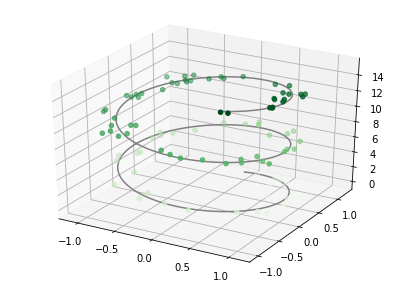

In [4]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

In [5]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  

def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y, )
Z = f(X, Y)

print('X.shape ', X.shape)
print('Y.shape ', Y.shape)
print('Z.shape ', Z.shape)

X.shape  (30, 30)
Y.shape  (30, 30)
Z.shape  (30, 30)


Text(0.5, 0, 'z')

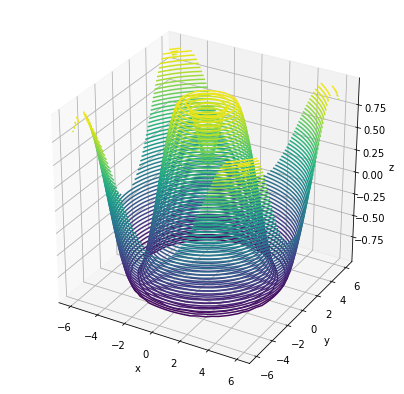

In [6]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# plt.show()

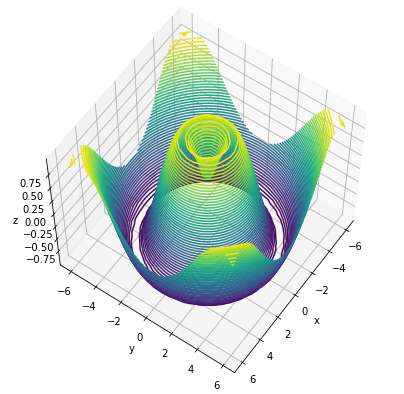

In [7]:
ax.view_init(60, 35)
fig

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot(rstride=1, cstride=1):

  fig = plt.figure(figsize=(7,7))
  ax = plt.axes(projection='3d')
  ax.plot_surface(X, Y, Z, rstride=rstride, cstride=cstride,
                  cmap='viridis', edgecolor='none')
  ax.set_title('surface');

In [9]:
_rstride = widgets.IntSlider(min=1, max=5, step=1, value=1)
_cstride = widgets.IntSlider(min=1, max=5, step=1, value=1)

interact(plot, rstride=_rstride, cstride=_cstride);

interactive(children=(IntSlider(value=1, description='rstride', max=5, min=1), IntSlider(value=1, description=…

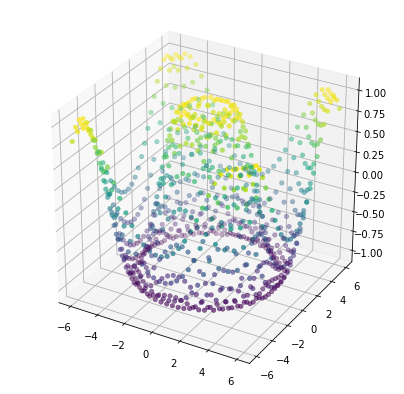

In [10]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')
ax.scatter(X, Y, Z, c=Z, cmap='viridis', linewidth=0.5);

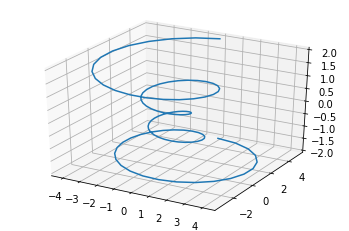

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z)
plt.show()

In [12]:
def plot(param1=-4, param2=4):
  resolution = 200
  fig = plt.figure(figsize=(7,7))
  ax = plt.axes(projection='3d')
  theta = np.linspace(param1 * np.pi, param2 * np.pi, resolution)
  z = np.linspace(-2, 2, resolution)
  r = z**2 + 1
  x = r * np.sin(theta)
  y = r * np.cos(theta)
  ax.plot(x, y, z)
  plt.show()

In [13]:
_param1 = widgets.IntSlider(min=-6, max=6, step=1, value=-4)
_param2 = widgets.IntSlider(min=-6, max=6, step=1, value=4)

interact(plot, param1=_param1, param2=_param2);

interactive(children=(IntSlider(value=-4, description='param1', max=6, min=-6), IntSlider(value=4, description…

## Na akkor ugorjunk bele

In [66]:
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)

In [67]:
print(zline.shape)
print(xline.shape)
print(yline.shape)

(1000,)
(1000,)
(1000,)


In [68]:
zdata = 15 * np.random.random(1000)
xdata = np.sin(zdata) + 0.1 * np.random.randn(1000)
ydata = np.cos(zdata) + 0.1 * np.random.randn(1000)

In [69]:
print(zdata.shape)
print(xdata.shape)
print(ydata.shape)

(1000,)
(1000,)
(1000,)


In [71]:
print('zline.max() =', zline.max())
print('zline.min() =', zline.min())
print('zdata.max() =', zdata.max())
print('zdata.min() =', zdata.min())

zline = zline / zline.max()
zdata = zdata / zdata.max()

print('zline.max() =', zline.max())
print('zline.min() =', zline.min())
print('zdata.max() =', zdata.max())
print('zdata.min() =', zdata.min())

zline.max() = 15.0
zline.min() = 0.0
zdata.max() = 14.960751440362614
zdata.min() = 0.017979490767653927
zline.max() = 1.0
zline.min() = 0.0
zdata.max() = 1.0
zdata.min() = 0.001201777252922407


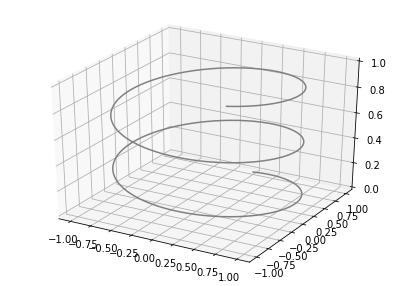

In [72]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
ax.plot3D(xline, yline, zline, 'gray')
plt.show()

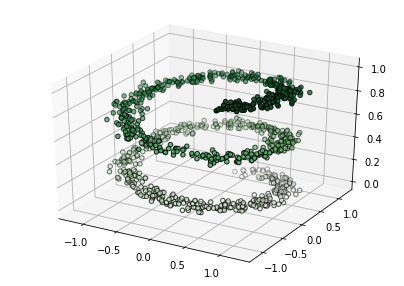

In [73]:
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens', linewidth=1, edgecolor='black');

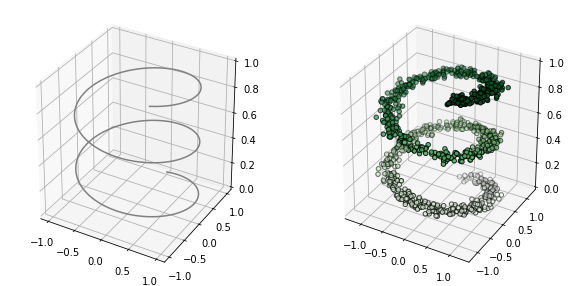

In [74]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for a three-dimensional line
ax.plot3D(xline, yline, zline, 'gray')
ax.set_zlim(bottom=0, top=1)


ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

plt.show()

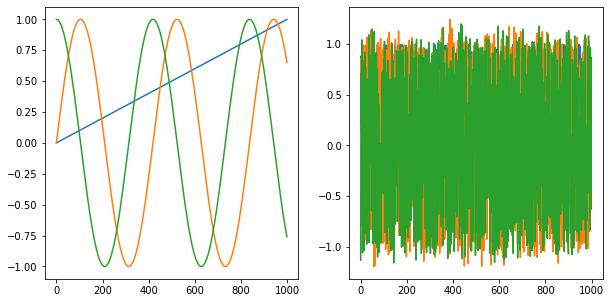

In [75]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(zline); ax1.plot(xline); ax1.plot(yline)
ax2.plot(zdata); ax2.plot(xdata); ax2.plot(ydata)
plt.show()

In [106]:
# Első próba

# simán az x,y alapján a z-t

import keras

bemenet = 2
kimenet = 1

# define the model
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=bemenet, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(kimenet))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                60        
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [91]:
input_vars  = np.array([xline, yline]).T
output_var = np.array([zline]).T.flatten()

print(input_vars.shape)
print(output_var.shape)

(1000, 2)
(1000,)


In [107]:
history = model.fit(input_vars, output_var, verbose=1, epochs=20, batch_size=32)

Epoch 1/20
32/32 [==============================] - 0s 1ms/step - loss: 0.2545
Epoch 2/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1421
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1179
Epoch 4/20
32/32 [==============================] - 0s 1ms/step - loss: 0.1040
Epoch 5/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0952
Epoch 6/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0901
Epoch 7/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0871
Epoch 8/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0854
Epoch 9/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0843
Epoch 10/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0835
Epoch 11/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0833
Epoch 12/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0833
Epoch 13/20
32/32 [==============================

In [108]:
mse = model.evaluate(input_vars, output_var, verbose=0)
print('mse =', mse)

mse = 0.08186319470405579


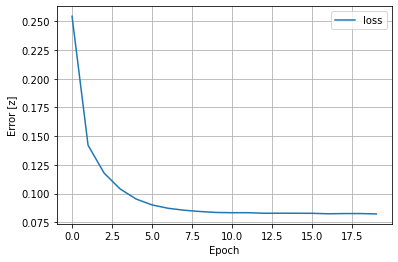

In [109]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  # plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [z]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [110]:
predicted_output = model.predict(input_vars).flatten()

In [112]:
predicted_output.shape

(1000,)

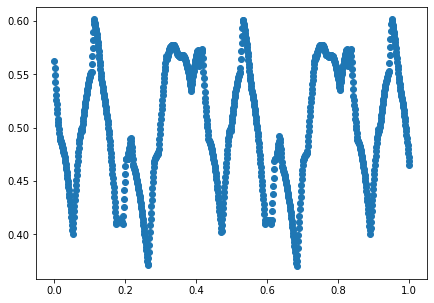

In [113]:
plt.figure(figsize=(7,5))
plt.scatter(output_var, predicted_output)
plt.show()

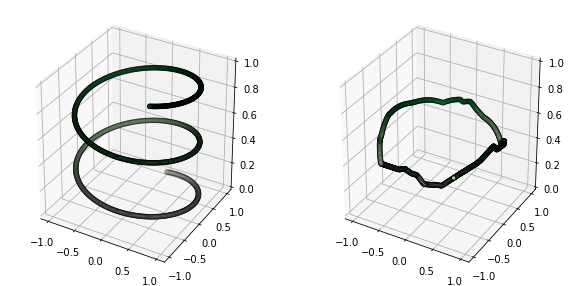

In [114]:
fig = plt.figure(figsize=(10, 5))

_z = zline

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, _z, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_z = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, _z, c=_z, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

In [115]:
# Hát igen az nyilvánvaló, hogy (x,y) alapján nem lehet megmondani a z értéket

In [ ]:
# Második probálkozás

# (x,z) -> y



In [116]:
input_vars  = np.array([xline, zline]).T
output_var = np.array([yline]).T.flatten()

print(input_vars.shape)
print(output_var.shape)

(1000, 2)
(1000,)


In [117]:
import keras

bemenet = 2
kimenet = 1

# define the model
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=bemenet, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(kimenet))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 20)                60        
                                                                 
 dense_9 (Dense)             (None, 1)                 21        
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [118]:
history = model.fit(input_vars, output_var, verbose=1, epochs=20, batch_size=32)

Epoch 1/20
32/32 [==============================] - 0s 1ms/step - loss: 0.6512
Epoch 2/20
32/32 [==============================] - 0s 1ms/step - loss: 0.5126
Epoch 3/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4936
Epoch 4/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4905
Epoch 5/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4878
Epoch 6/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4863
Epoch 7/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4840
Epoch 8/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4831
Epoch 9/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4806
Epoch 10/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4786
Epoch 11/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4777
Epoch 12/20
32/32 [==============================] - 0s 2ms/step - loss: 0.4768
Epoch 13/20
32/32 [==============================

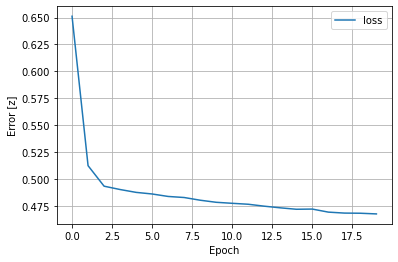

In [119]:
plot_loss(history)

In [120]:
predicted_output = model.predict(input_vars).flatten()

predicted_output.shape

(1000,)

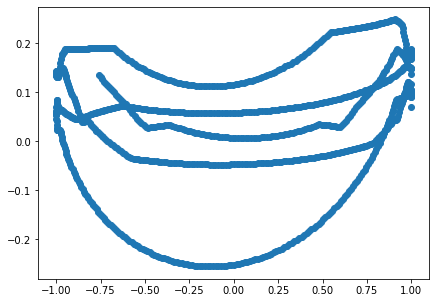

In [121]:
plt.figure(figsize=(7,5))
plt.scatter(output_var, predicted_output)
plt.show()

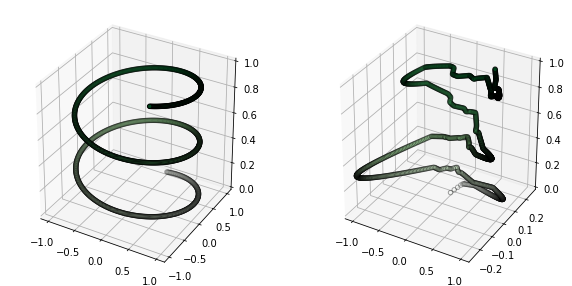

In [122]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_yline = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, _yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

In [123]:
# nem tudom

# két helyen mehetett el

# 1, nem volt {0,1} közé normalizálva az x és az y
# 2, egy réteg kevés volt ehhez
# 3, az átviteli függvény sem biztos, hogy jó, hogy relu

# maradjon minden ki bemeneti változó ugyan az, de próbáljuk meg több
# rétegen (2) és más átviteli függvénnyel (3)

In [137]:
import keras

bemenet = 2
kimenet = 1

# define the model
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=bemenet, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(20, kernel_initializer='he_uniform', activation='relu'))
model.add(keras.layers.Dense(kimenet))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 20)                60        
                                                                 
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [138]:
history = model.fit(input_vars, output_var, verbose=0, epochs=200, batch_size=32)

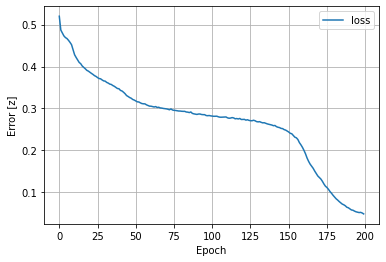

In [139]:
plot_loss(history)

In [140]:
predicted_output = model.predict(input_vars).flatten()

predicted_output.shape

(1000,)

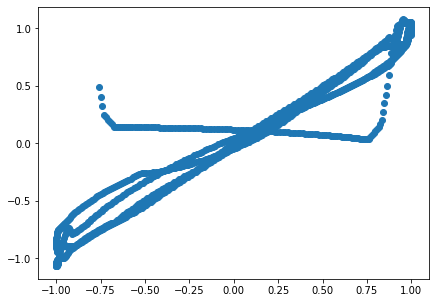

In [141]:
plt.figure(figsize=(7,5))
plt.scatter(output_var, predicted_output)
plt.show()

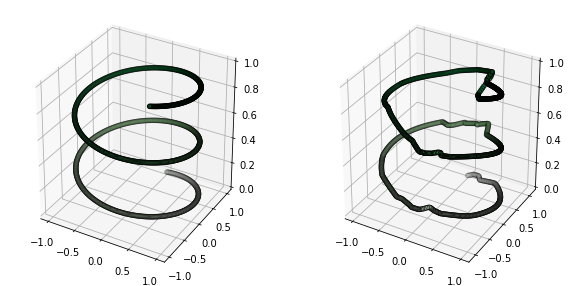

In [142]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_yline = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, _yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

In [143]:
# Na ez már jobban néz ki

# Próbáljuk meg más átviteli függvénnyel

In [144]:
import keras

bemenet = 2
kimenet = 1

activation = 'sigmoid' # 'relu', 'tanh'

# define the model
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=bemenet, kernel_initializer='he_uniform', activation=activation))
model.add(keras.layers.Dense(20, kernel_initializer='he_uniform', activation=activation))
model.add(keras.layers.Dense(kimenet))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 20)                60        
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


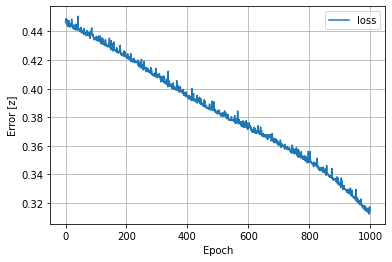

In [153]:
history = model.fit(input_vars, output_var, verbose=0, epochs=200, batch_size=32)

plot_loss(history)

In [154]:
predicted_output = model.predict(input_vars).flatten()

predicted_output.shape

(1000,)

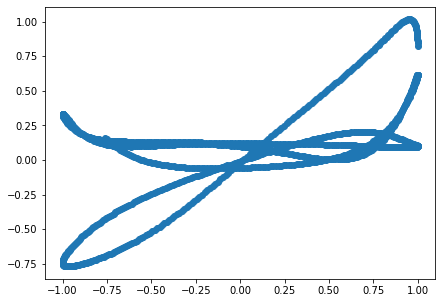

In [155]:
plt.figure(figsize=(7,5))
plt.scatter(output_var, predicted_output)
plt.show()

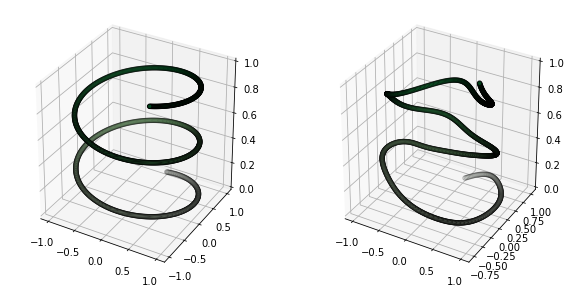

In [156]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_yline = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, _yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

In [157]:
# Nem az igazi

# Próbáljuk meg tanh átviteli függvénnyel, még mindíg nem normalizáltunk

In [ ]:
# Na ez már jobban néz ki

# Próbáljuk meg más átviteli függvénnyel

In [192]:
import keras

bemenet = 2
kimenet = 1

activation = 'tanh' # 'relu', 'sigmoid'

# define the model
model = keras.Sequential()
# model.add(keras.layers.Dense(20, input_dim=bemenet, kernel_initializer='he_uniform', activation=activation))
model.add(keras.layers.Dense(20, input_dim=bemenet, activation=activation))
model.add(keras.layers.Dense(20, activation=activation))
model.add(keras.layers.Dense(kimenet))
model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 20)                60        
                                                                 
 dense_42 (Dense)            (None, 20)                420       
                                                                 
 dense_43 (Dense)            (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


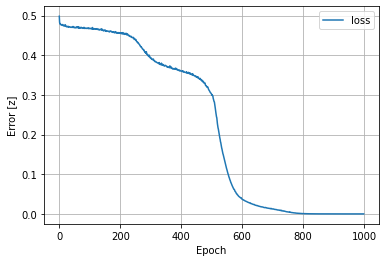

In [193]:
history = model.fit(input_vars, output_var, verbose=0, epochs=1000, batch_size=64)

plot_loss(history)

In [194]:
predicted_output = model.predict(input_vars).flatten()

predicted_output.shape

(1000,)

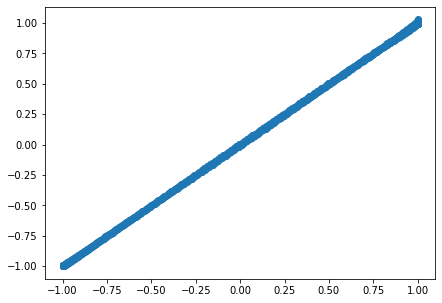

In [195]:
plt.figure(figsize=(7,5))
plt.scatter(output_var, predicted_output)
plt.show()

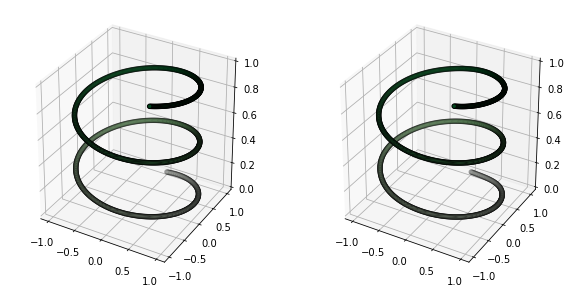

In [196]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_yline = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, _yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

In [197]:
# Ugyan ez Functional API segítségével

In [198]:
bemenet = 2
kimenet = 1

activation = 'tanh'

neural_net_inputs = tf.keras.Input(shape=(bemenet,))
dense_layer_1     = tf.keras.layers.Dense(units=20, activation=activation)(neural_net_inputs)
dense_layer_2     = tf.keras.layers.Dense(units=20, activation=activation)(dense_layer_1)
output_layer      = tf.keras.layers.Dense(units=kimenet)(dense_layer_2)

model             = tf.keras.Model(inputs=neural_net_inputs, outputs=output_layer)

model.compile(loss='mse', optimizer='adam')


In [199]:
history = model.fit(input_vars, output_var, verbose=0, epochs=1000, batch_size=64)

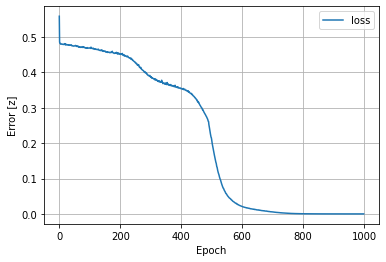

In [200]:
plot_loss(history)

In [201]:
predicted_output = model.predict(input_vars).flatten()

predicted_output.shape

(1000,)

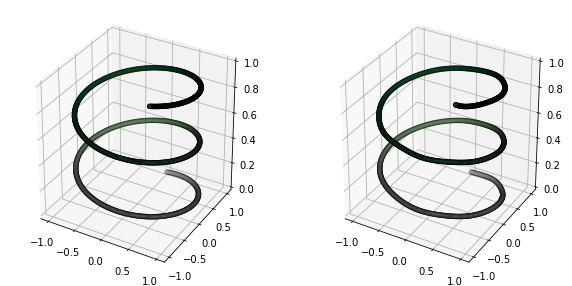

In [202]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_yline = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, _yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

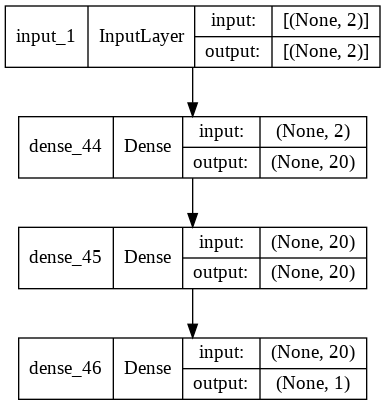

In [205]:
# from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [211]:
score = model.evaluate(input_vars, output_var, verbose=1)

print("Model Score [loss, mse]:", score)


32/32 [==============================] - 0s 1ms/step - loss: 7.7402e-05
Model Score [loss, mse]: 7.74021100369282e-05


In [212]:
# Csak a vicc kedvéért próbáljuk ki, hogy két különböző architecturát
# csinálok és a végén összekötöm őket

In [214]:
input_1 = tf.keras.Input(shape=(1,))
input_2 = tf.keras.Input(shape=(1,))

m1_dense_layer_1     = tf.keras.layers.Dense(units=20, activation=activation)(input_1)
m1_dense_layer_2     = tf.keras.layers.Dense(units=20, activation=activation)(m1_dense_layer_1)

m2_dense_layer_1     = tf.keras.layers.Dense(units=20, activation=activation)(input_2)
m2_dense_layer_2     = tf.keras.layers.Dense(units=20, activation=activation)(m2_dense_layer_1)

kimenet = 1

concat_layer         = tf.keras.layers.Concatenate()([m1_dense_layer_2, m2_dense_layer_2])
dense_layer_3        = tf.keras.layers.Dense(10, activation=activation)(concat_layer)
output_layer         = tf.keras.layers.Dense(kimenet)(dense_layer_3)

model                = tf.keras.Model(inputs=[input_1, input_2], outputs=output_layer)

model.compile(loss='mse', optimizer='adam')

model.summary()



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_53 (Dense)               (None, 20)           40          ['input_4[0][0]']                
                                                                                                  
 dense_55 (Dense)               (None, 20)           40          ['input_5[0][0]']                
                                                                                            

In [215]:
input_var_1  = np.array([xline]).T
input_var_2  = np.array([zline]).T
output_var   = np.array([yline]).T.flatten()

print(input_var_1.shape)
print(input_var_2.shape)
print(output_var.shape)

(1000, 1)
(1000, 1)
(1000,)


In [217]:
history = model.fit(x=[input_var_1, input_var_2], y=output_var, verbose=0, epochs=1000, batch_size=64)

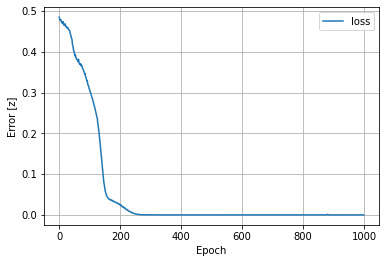

In [218]:
plot_loss(history)

In [220]:
predicted_output = model.predict([input_var_1, input_var_2]).flatten()

predicted_output.shape

(1000,)

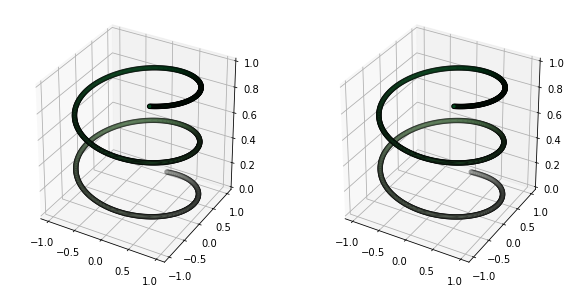

In [221]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)

_yline = predicted_output.flatten()

ax = fig.add_subplot(1, 2, 2, projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(xline, _yline, zline, c=zline, cmap='Greens', linewidth=1, edgecolor='black');
ax.set_zlim(bottom=0, top=1)
plt.show()

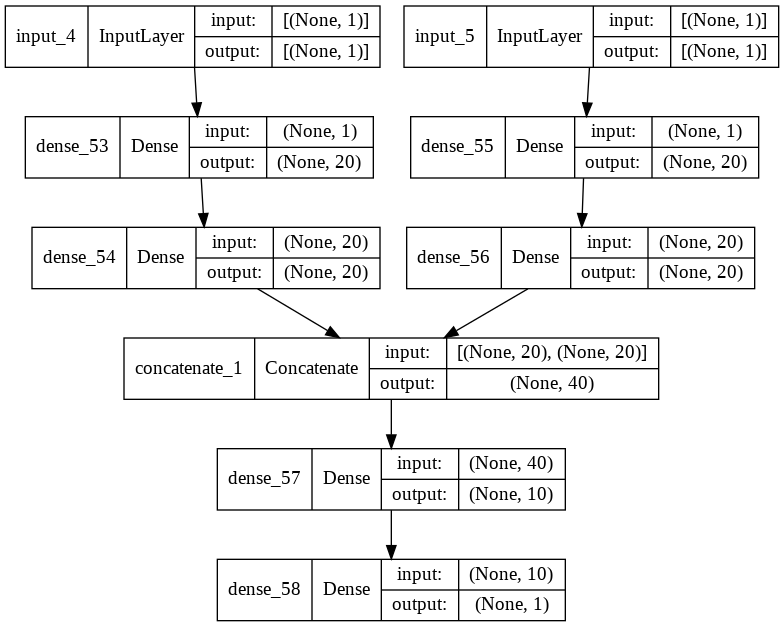

In [222]:
# from tensorflow.keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [223]:
score = model.evaluate([input_var_1, input_var_2], output_var, verbose=1)

print("Model Score [loss, mse]:", score)

32/32 [==============================] - 0s 1ms/step - loss: 3.3799e-05
Model Score [loss, mse]: 3.379860572749749e-05


In [224]:
model.save('concatenated')

INFO:tensorflow:Assets written to: concatenated/assets


In [225]:
!zip -r concatenated.zip concatenated

  adding: concatenated/ (stored 0%)
  adding: concatenated/assets/ (stored 0%)
  adding: concatenated/keras_metadata.pb (deflated 91%)
  adding: concatenated/saved_model.pb (deflated 89%)
  adding: concatenated/variables/ (stored 0%)
  adding: concatenated/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: concatenated/variables/variables.index (deflated 69%)


In [226]:
!rm -rf concatenated

In [ ]:
# Na ezt nem tettem fel de akár fel is tehetném

# !wget https://github.com/JoDeMiro/Face/raw/main/concatenated.zip

# !unzip concatenated.zip

In [ ]:
model = keras.models.load_model('concatenated')

In [227]:
y_predicted = model.predict([input_var_1, input_var_2])

y_predicted[0:10]

array([[1.005],
       [1.003],
       [1.001],
       [0.999],
       [0.997],
       [0.995],
       [0.993],
       [0.99 ],
       [0.988],
       [0.985]], dtype=float32)

In [ ]:
# https://en.wikipedia.org/wiki/Stochastic_gradient_descent

# arra az esetre, ha meg akarok őrülni

In [ ]:
# https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

# ez is olyan ami alapján lehet cikket írni, alapanyag

In [ ]:
# https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

# olvastam egy sexy cikket
# a batch_size jelentőségéről

# van ahol a batch size nagyon kicsi (n=1 -> sgd), de van olyan is, hogy teljes mintát odaadja neki